## **Fraud Detection using Python**


A typical organization loses an estimated 5% of its yearly revenue to fraud. In this project, we will try to fight fraud by using data by applying supervised learning algorithms to detect fraudulent behavior based upon past fraud. 

Fraudulent transactions are rare compared to the norm.  As such, we need to properly classify imbalanced datasets.

The project demonstrates how to implement fraud detection model and prevent common mistakes in fraud analytics.

**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

**Pandas Configuration Options**

In [3]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

# Introduction and Data Preparation

### Checking the fraud to non-fraud ratio

We will work on `creditcard_sampledata.csv`, a dataset containing credit card transactions data. Fraud occurrences are fortunately an **extreme minority** in these transactions.

However, Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as **class imbalance**, and it's one of the main challenges of fraud detection.

Let's explore this dataset, and observe this class imbalance problem.

In [4]:
df = pd.read_csv('creditcard_sampledata_2.csv')

### Explore the features available in your dataframe

In [5]:
df.shape

(7300, 31)

In [6]:
#df.info()

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [8]:
# Checking for missing values
df.isnull().sum().sum()

0

In [9]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    7000
1     300
Name: Class, dtype: int64

In [10]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.0410958904109589
Ratio of non-fraudulent cases: 0.958904109589041


**The ratio of fraudulent transactions is very low. This is a case of class imbalance problem, and we have to deal with this in the next steps.**

### Visualize the fraud to non-fraud ratio

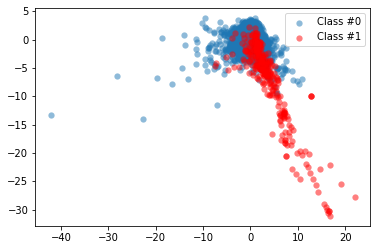

In [11]:
# Plot our data to Visualize the fraud and non-fraud cases
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

**By visualizing the data, we can immediately see how our fraud cases are scattered over our data, and how few cases we have.**

## Increase successful detections with data resampling

* resampling can help model performance in cases of imbalanced data sets

#### Undersampling
* Undersampling the majority class (non-fraud cases)
    * Straightforward method to adjust imbalanced data
    * Take random draws from the non-fraud observations, to match the occurences of fraud observations.

#### Oversampling

* Oversampling the minority class (fraud cases)
    * Take random draws from the fraud cases and copy those observations to increase the amount of fraud samples
* Both methods lead to having a balance between fraud and non-fraud cases
* Drawbacks
    * with random undersampling, a lot of information is thrown away
    * with oversampling, the model will be trained on a lot of duplicates

### Implement resampling methods using Python imblearn module

#### SMOTE

* Synthetic minority Oversampling Technique (SMOTE)
    * [Resampling strategies for Imbalanced Data Sets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
    * Way of adjusting the imbalance by oversampling minority observations
    * SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases
        * avoids duplicating observations
        * only works well if the minority case features are similar
        * if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases

### Applying Synthetic Minority Oversampling Technique (SMOTE)

In this project, we're going to re-balance our data using the **Synthetic Minority Over-sampling Technique** (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but **creates new, synthetic, samples** that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so let's apply SMOTE to our credit card data.


#### Create features X and labels y
    X: data columns (V1 - V28)
    y: lable column

In [12]:
# Create X and y features
X = df.iloc[:, 2:30].values
y = df.Class.values

In [13]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (7300, 28)
y shape: (7300,)


In [14]:
# Define the resampling method
method = SMOTE(random_state=108)

In [15]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

(14000, 28) (14000,)


1    7000
0    7000
dtype: int64

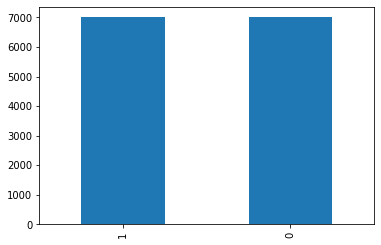

In [16]:
# Plot the resampled data
print(X_resampled.shape, y_resampled.shape)
pd.value_counts(pd.Series(y_resampled)).plot(kind='bar')
pd.value_counts(pd.Series(y_resampled))

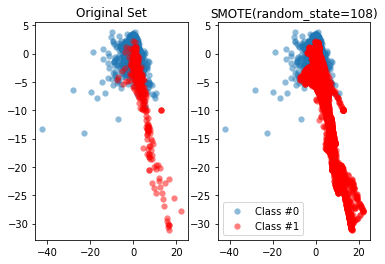

In [17]:
plt.subplot(1, 2, 1)
plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title('Original Set')
plt.subplot(1, 2, 2)
plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title(method)
plt.legend()
plt.show()

**The minority class is now much more prominently visible in our data.**

### Using Logistic Regression classification to catch fraud

let's implement a **Logistic Regression** model. First we will apply LR on imbalanced dataset and later on compare our results by applying LR on rebalanced dataset.

In [18]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [20]:
# Obtain model predictions
predicted = model.predict(X_test)

In [21]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.82      0.88        91

    accuracy                           0.99      2190
   macro avg       0.96      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190

Confusion matrix:
 [[2094    5]
 [  16   75]]


**Let's now explore whether we can improve the prediction results even further with resampling methods.**

### Logistic regression with SMOTE

we're going to take the Logistic Regression model and combine that with a **SMOTE resampling method**. We'll see you how to do that efficiently by using a pipeline that combines the resampling method with the model in one go. First, we need to define the pipeline that we're going to use.


In [22]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has beeen changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [23]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

### Pipelining

Now that you have our pipeline defined, aka **combining a logistic regression with a SMOTE method**, let's run it on the data. we can treat the pipeline as if it were a **single machine learning model**.

In [24]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [26]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.66      0.86      0.75        91

    accuracy                           0.98      2190
   macro avg       0.83      0.92      0.87      2190
weighted avg       0.98      0.98      0.98      2190

Confusion matrix:
 [[2059   40]
 [  13   78]]


**The SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives. Resampling doesn't necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. Let's adjust our machine learning models to better detect the minority fraud cases.**

### Natural hit rate

First we need to explore how prevalent fraud is in the dataset, to understand what the **"natural accuracy"** is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" we need to "beat" in order to get a **better prediction than by doing nothing**. we'll create our first random forest classifier for fraud detection. That will serve as the **"baseline"** model that we're going to try to improve in the further steps.


In [27]:
df.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [28]:
# Count the total number of observations from the length of y
total_obs = len(y)
total_obs

7300

In [29]:
# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

7000

In [30]:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

95.89%


**This tells us that by doing nothing, we would be correct in 95.9% of the cases. If we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.**

### Random Forest Classifier

Let's now create a first **random forest classifier** for fraud detection. Hopefully we can do better than the baseline accuracy you've just calculated, which was roughly **96%**. This model will serve as the **"baseline" model** that we're going to try to improve in the upcoming steps.

#### X_train, X_test, y_train, y_test

In [31]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

Let's see how our Random Forest model performs **without doing anything special to it**.

In [33]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [34]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

Obtain and print the accuracy score by comparing the actual labels `y_test` with our predicted labels `predicted`.

In [35]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.991


## Perfomance evaluation

* Performance metrics for fraud detection models
* There are other performace metrics that are more informative and reliable than accuracy

#### Accuracy

* Accuracy isn't a reliable performance metric when working with highly imbalanced data (such as fraud detection)
* By doing nothing, aka predicting everything is the majority class, a higher accuracy is obtained than by trying to build a predictive model.

#### Precision Recall

* Credit card company wants to optimize for recall
* Insurance company wants to optimize for precision
* Precision:
    * $$Precision=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Positives}$$
    * Fraction of actual fraud cases out of all predicted fraud cases
        * true positives relative to the sum of true positives and false positives
* Recall:
    * $$Recall=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Negatives}$$
    * Fraction of predicted fraud cases out of all actual fraud cases
        * true positives relative to the sum of true positives and false negative
* Precision and recall are typically inversely related
    * As precision increases, recall falls and vice-versa

#### F-Score

* Weighs both precision and recall into on measure

\begin{align}
F-measure = \frac{2\times{Precision}\times{Recall}}{Precision\times{Recall}} \\ 
\\
= \frac{2\times{TP}}{2\times{TP}+FP+FN}
\end{align}

* is a performance metric that takes into account a balance between Precision and Recall

#### Receiver Operating Characteristic (ROC) curve to compare algorithms

* Created by plotting the true positive rate against the false positive rate at various threshold settings
* Useful for comparing performance of different algorithms

### Performance metrics for the RF model

We obtained an accuracy score for our random forest model. This time, we know **accuracy can be misleading** in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the **classification report** tells us about the precision and recall of our model, whilst the **confusion matrix** actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

In [36]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

In [37]:
# Predict probabilities
probs = model.predict_proba(X_test)

In [38]:
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


**The model predicts 75 cases of fraud, out of which 73 are actual fraud. You have only 2 false positives. This is really good, and as a result we have a very high precision score. we do however, miss 18 cases of actual fraud. Recall is therefore not as good as precision.**

### Parameter optimization with GridSearchCV

With `GridSearchCV` we can define **which performance metric to score** the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the best possible Recall score. If you also cared about reducing the number of false positives, you could optimize on F1-score, this gives you that nice Precision-Recall trade-off.


In [39]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

### Model results with GridSearchCV

we discovered that the **best parameters for your model** are that the split criterion should be set to `'gini'`, the number of estimators (trees) should be 30, the maximum depth of the model should be 8 and the maximum features should be set to `"log2"`.

### Model adjustments

A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **`class_weights` option** when defining the `sklearn` model. we'll **define weights manually**, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

In [40]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 12}, max_depth=8,
                       max_features='log2', min_samples_leaf=10,
                       n_estimators=30, n_jobs=-1, random_state=5)

In [41]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [42]:
# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


**The model has been improved even further. The number of false negetives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, we need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with.**

## Ensemble Method - Voting Classifier

Finally, we'll **combine three algorithms** into one model with the **VotingClassifier**. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. 
* The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. we'll also add a Decision Tree with balanced weights to it.
* As seen before, Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.
* Thus, We'll combine our optimal Random Forest model, with the Logistic Regression and with a simple Decision Tree.




In [43]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2090    9]
 [  13   78]]


**By combining the classifiers, we can take the best of multiple models. we've increased the cases of fraud you are catching from 76 to 78, and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together we indeed managed to improve performance.**

### Adjusting weights within the Voting Classifier

* Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to **adjust the weights** we give to these models. By increasing or decreasing weights we can play with **how much emphasis we give to a particular model** relative to the rest.
* The weight option allows you to play with the individual models to get the best final mix for your fraud detection model.